Get dataset from https://github.com/OlafenwaMoses/FireNET
combine train and validate source sets, as these are split in code

https://airctic.com/retinanet/

In [1]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [2]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [3]:
!rm  fire-dataset.zip

In [4]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [5]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [6]:
!rm  -r fire-dataset/validation/

In [7]:
!ls fire-dataset/train

annotations  images


Install from master

In [8]:
!pip install  icedata
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade

     |████████████████████████████████| 112kB 15.3MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 1.8MB 46.8MB/s 
     |████████████████████████████████| 552kB 38.1MB/s 
     |████████████████████████████████| 112kB 28.8MB/s 
     |████████████████████████████████| 194kB 57.7MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 952kB 38.6MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 163kB 54.8MB/s 
     |████████████████████████████████| 133kB 58.5MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
  

In [9]:
from icevision.all import *

In [10]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [11]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [12]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/img (6).jpg'),
 Path('fire-dataset/train/images/pic (15).jpg'),
 Path('fire-dataset/train/images/pic (204).jpg')]

In [13]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/img (35).xml'),
 Path('fire-dataset/train/annotations/small (45).xml'),
 Path('fire-dataset/train/annotations/small (37).xml')]

In [14]:
class_map = ClassMap(['fire'])

In [28]:
class_map

<ClassMap: {'background': 0, 'fire': 1}>

In [15]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [16]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

INFO     - Autofixing records | icevision.parsers.parser:parse:124


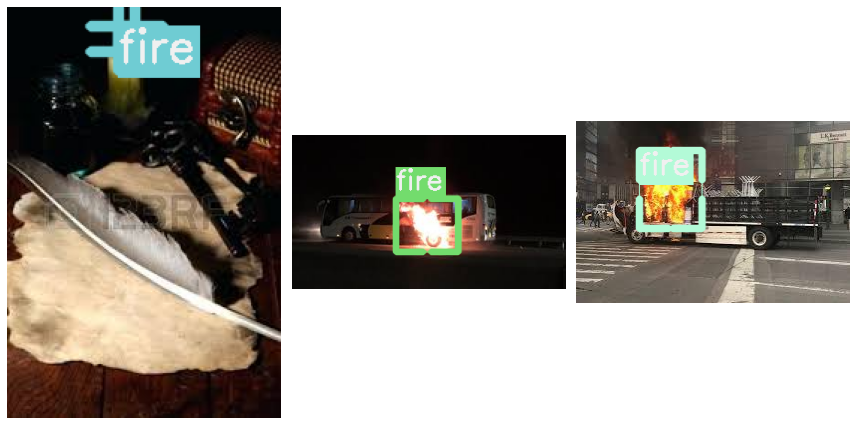

In [17]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [18]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [19]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

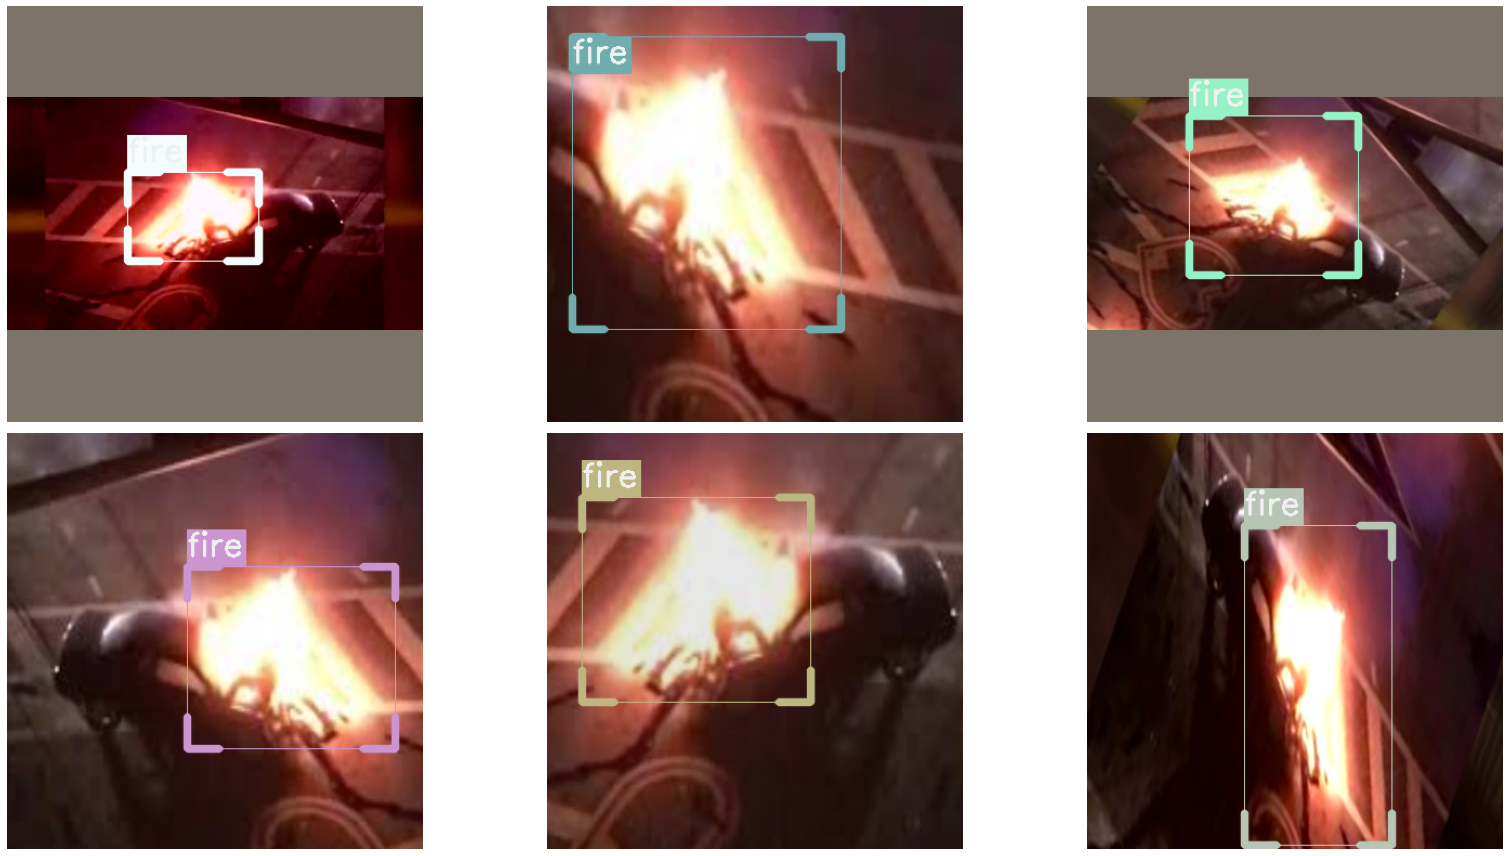

In [29]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

In [21]:
model = retinanet.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [30]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

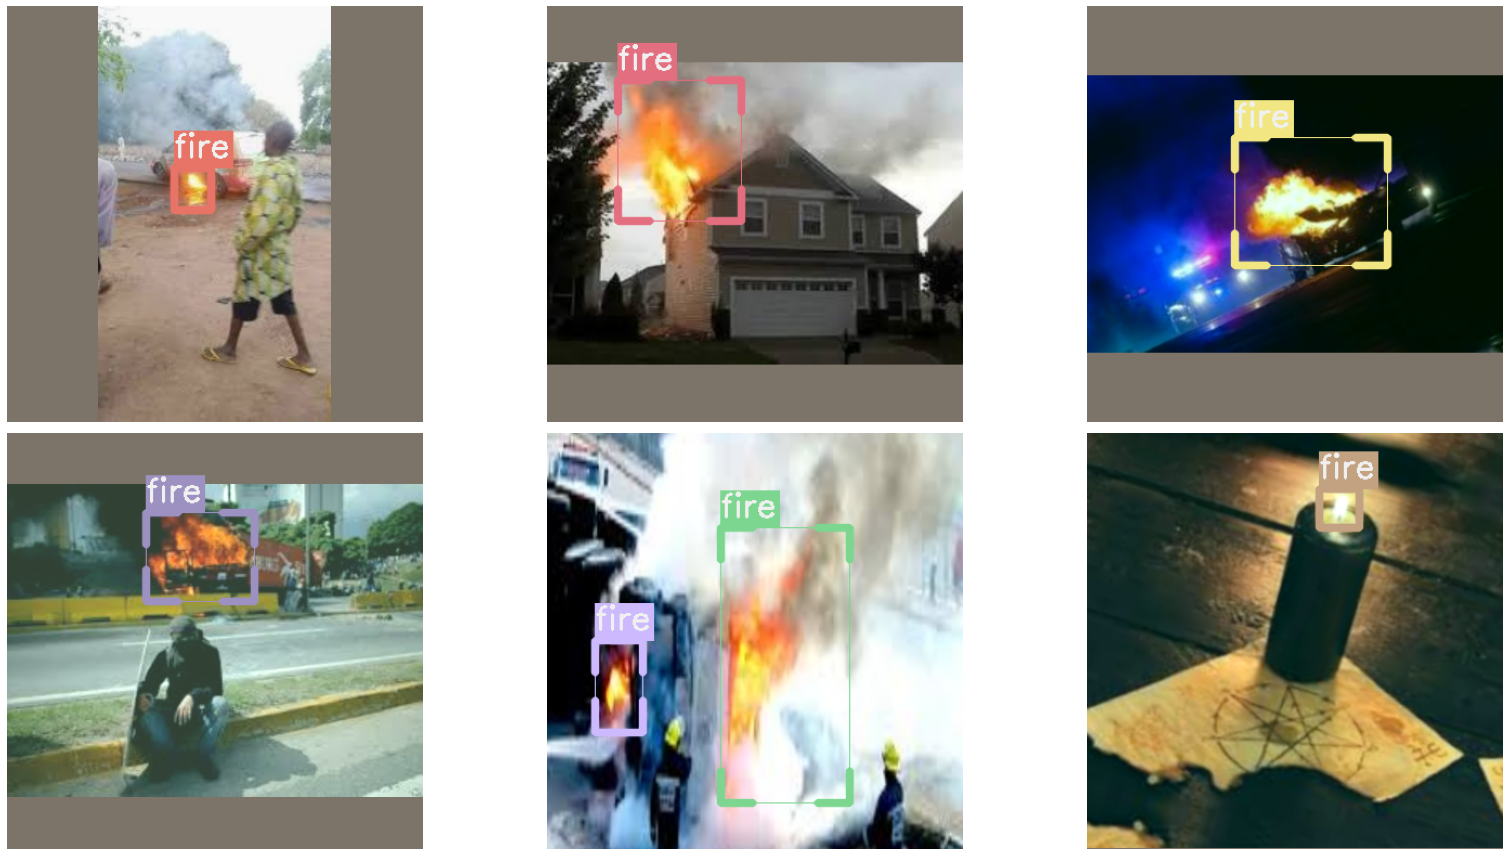

In [31]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

IceVision is an agnostic framework meaning it can be plugged to multiple DL frameworks such as fastai, and pytorch-lightning. 

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [23]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [25]:
# Fastai Learner
learn = retinanet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [26]:
learn.freeze()
learn.lr_find()

AttributeError: ignored

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

Now:
* Phase 1: Train the head for 10 epochs while freezing the body
* Phase 2: Train both the body and the head during 50 epochs

In [27]:
learn.fine_tune(50, 3e-2, freeze_epochs=10)

TypeError: ignored

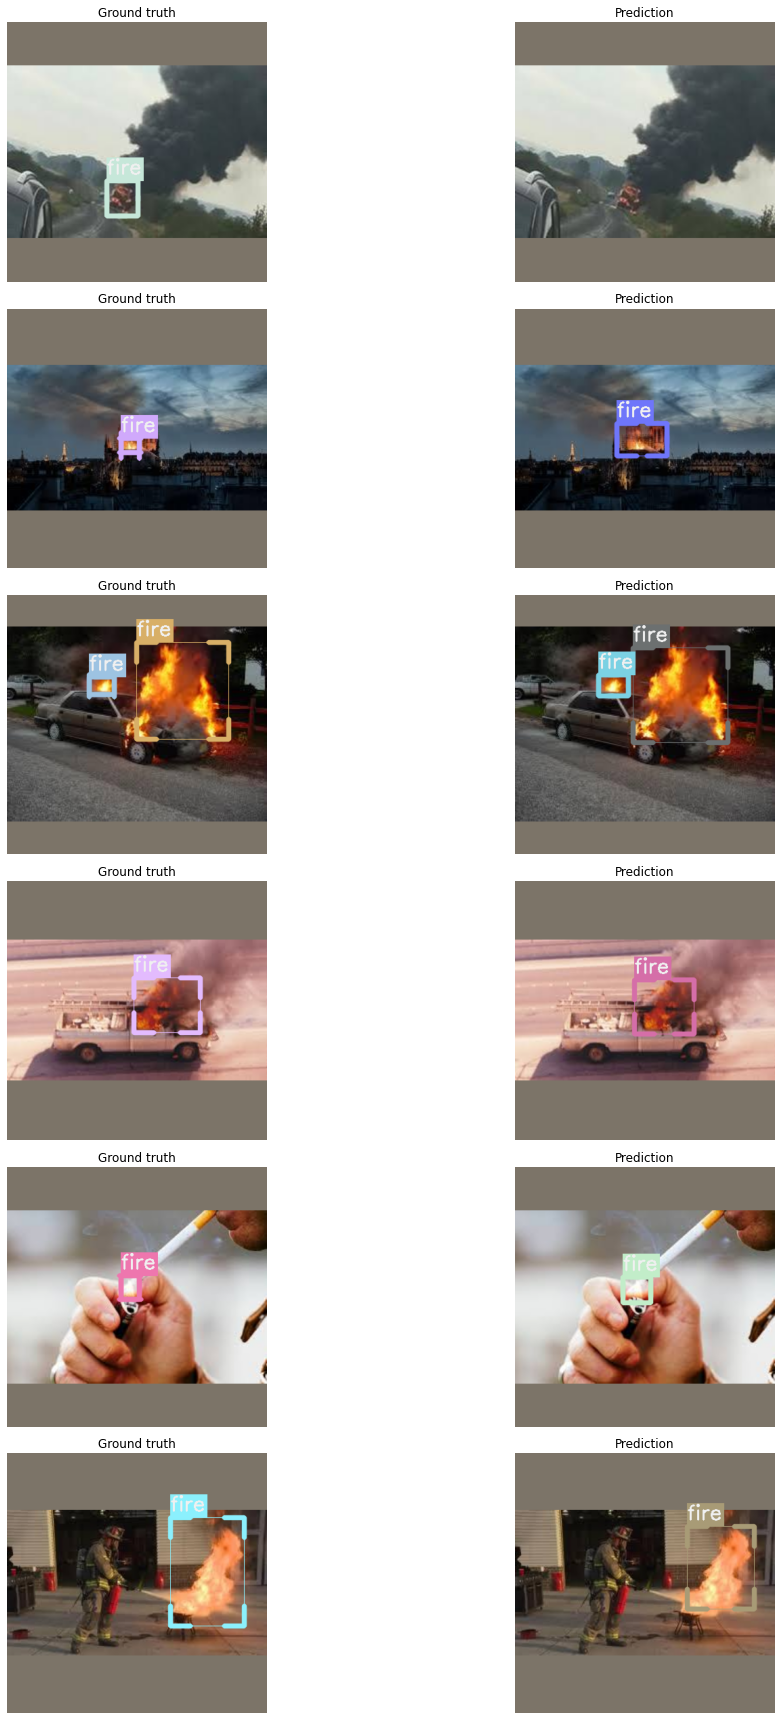

In [ ]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [ ]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/efficientdet_fire.pth')

Mounted at /content/gdrive


`"efficientdet_fire.pth" (13MB)`

In [ ]:
ls

fire-dataset/  gdrive/  models/  sample_data/
